# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install -U kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "danielpmathews"
kaggle_key = "6b4d5550ca29d4bf26a121eacdeeb293"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [3]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240625_234407"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri May 31 18:15:42 UTC 2024
CPU Count:          2
Memory Avail:       2.75 GB / 3.78 GB (72.6%)
Disk Space Avail:   8589934588.87 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

(_ray_fit pid=508) [1000]	valid_set's rmse: 130.657
(_ray_fit pid=593) [1000]	valid_set's rmse: 132.725 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=621) [2000]	valid_set's rmse: 126.702 [repeated 2x across cluster]
(_ray_fit pid=621) [5000]	valid_set's rmse: 125.681 [repeated 4x across cluster]
(_ray_fit pid=650) [4000]	valid_set's rmse: 133.013 [repeated 5x across cluster]
(_ray_fit pid=650) [7000]	valid_set's rmse: 132.416 [repeated 4x across cluster]
(_ray_fit pid=677) [1000]	valid_set's rmse: 137.712 [repeated 2x across cluster]
(_ray_fit pid=677) [4000]	valid_set's rmse: 135.344 [repeated 3x across cluster]
(_ray_fit pid=677) [7000]	valid_set's rmse: 135.236 [repeated 5x across cluster]


(_dystack pid=388) 	-131.9758	 = Validation score   (-root_mean_squared_error)
(_dystack pid=388) 	77.08s	 = Training   runtime
(_dystack pid=388) 	11.36s	 = Validation runtime
(_dystack pid=388) Fitting model: LightGBM_BAG_L1 ... Training model for up to 7.72s of the 55.26s of remaining time.
(_dystack pid=388) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.46%)
(_dystack pid=388) 	-132.1374	 = Validation score   (-root_mean_squared_error)
(_dystack pid=388) 	27.55s	 = Training   runtime
(_dystack pid=388) 	0.79s	 = Validation runtime
(_dystack pid=388) Fitting model: WeightedEnsemble_L2 ... Training model for up to 142.61s of the 21.04s of remaining time.
(_dystack pid=388) 	Ensemble Weights: {'KNeighborsDist_BAG_L1': 1.0}
(_dystack pid=388) 	-89.9469	 = Validation score   (-root_mean_squared_error)
(_dystack pid=388) 	0.02s	 = Training   runtime
(_dystack pid=388) 	0.0s	 = Validation runtime
(_dystack p

(_ray_fit pid=957) [1000]	valid_set's rmse: 70.748 [repeated 5x across cluster]
(_ray_fit pid=1012) [1000]	valid_set's rmse: 77.3104 [repeated 2x across cluster]
(_ray_fit pid=1067) [1000]	valid_set's rmse: 76.5703 [repeated 2x across cluster]
(_ray_fit pid=1123) [1000]	valid_set's rmse: 73.0365 [repeated 2x across cluster]


(_dystack pid=388) 	-73.9683	 = Validation score   (-root_mean_squared_error)
(_dystack pid=388) 	38.79s	 = Training   runtime
(_dystack pid=388) 	2.68s	 = Validation runtime
(_dystack pid=388) Fitting model: WeightedEnsemble_L3 ... Training model for up to 142.61s of the -24.35s of remaining time.
(_dystack pid=388) 	Ensemble Weights: {'LightGBMXT_BAG_L2': 0.955, 'KNeighborsDist_BAG_L1': 0.045}
(_dystack pid=388) 	-73.9294	 = Validation score   (-root_mean_squared_error)
(_dystack pid=388) 	0.04s	 = Training   runtime
(_dystack pid=388) 	0.0s	 = Validation runtime
(_dystack pid=388) AutoGluon training complete, total runtime = 167.35s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 81.5 rows/s (1210 batch size)
(_dystack pid=388) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240625_234407/ds_sub_fit/sub_fit_ho")
(_dystack pid=388) Deleting DyStack predictor artifacts (clean_up_fits=True) ...
Leaderboard on holdout d

### Review AutoGluon's training run with ranking of models that did the best.

In [13]:
predictor = TabularPredictor.load('AutogluonModels/ag-20240625_234407')

In [ ]:
predictor.fit_summary()

### Create predictions from test dataset

In [15]:
predictions = predictor.predict(test)
predictions.head()

0    24.021990
1    43.417591
2    46.283195
3    49.363735
4    52.423946
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [16]:
# How many negative values do we have?
(predictions<0).sum()

0

In [17]:
# Set them to zero
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [56]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [57]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 671kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [58]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status   publicScore  privateScore  
--------------  -------------------  --------------------  -------  -----------  ------------  
submission.csv  2024-05-06 22:05:29  first raw submission  pending                             


#### Initial score of 1.80175

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

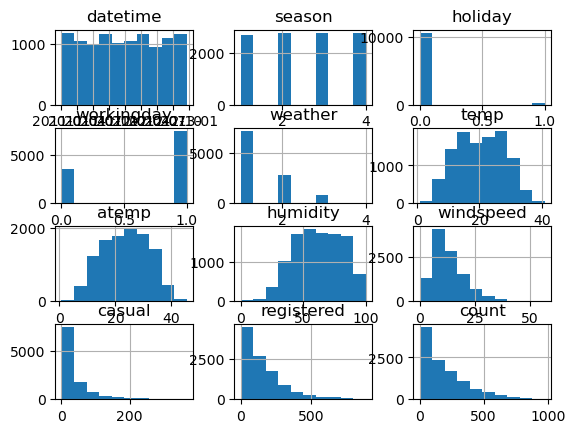

In [19]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [27]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month
train['day'] = train['datetime'].dt.day
test['day'] = test['datetime'].dt.day

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [32]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')

train["season"] = train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train["weather"] = train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [33]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,day
0,2011-01-01 00:00:00,NaN,0,0,NaN,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,NaN,0,0,NaN,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,NaN,0,0,NaN,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,NaN,0,0,NaN,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,NaN,0,0,NaN,9.84,14.395,75,0.0,0,1,1,4,1,1


In [ ]:
train.dtype

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'day'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

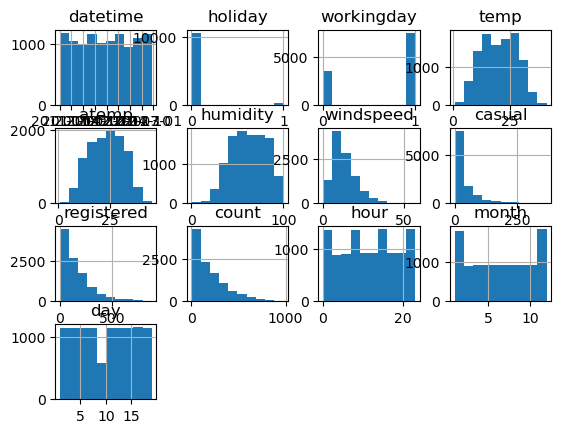

In [31]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240626_002033"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri May 31 18:15:42 UTC 2024
CPU Count:          2
Memory Avail:       1.43 GB / 3.78 GB (37.9%)
Disk Space Avail:   8589934588.87 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [ ]:
predictor_new_features.fit_summary()
predictions = predictor.predict(test)
predictions.head()

In [82]:
# Remember to set all negative values to zero
print((predictions<0).sum())
predictions[predictions<0] = 0

0


In [79]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 706kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-06 23:00:59  new features          complete  1.80175      1.80175       
submission.csv               2024-05-06 22:05:29  first raw submission  complete  1.80175      1.80175       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
predictor_new_hpo = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Remember to set all negative values to zero
?

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = ?
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})